<a href="https://colab.research.google.com/github/KhanhHa26/restaurant-embedding-map/blob/main/Restaurant_Embedding_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Dataset

I picked the **Yelp Dataset** from **Kaggle**, where it has all the datas about businesses. After getting the dataset, I filted out restaurants only, and then combined the data of **"name", "attributes", and "categories"** into a new column called "text" so that I could perform sentence-BERT later on 🙂

In [2]:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Choose a file inside the dataset
file_path = "yelp_academic_dataset_business.json"

df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "yelp-dataset/yelp-dataset",
    file_path,
    pandas_kwargs={"lines": True}
)

print(df.head())
print(df.shape)


Using Colab cache for faster access to the 'yelp-dataset' dataset.
              business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   
2             5255 E Broadway Blvd         Tucson    AZ       85711   
3                      935 Race St   Philadelphia    PA       19107   
4                    101 Walnut St     Green Lane    PA       18054   

    latitude   longitude  stars  review_count  is_open  \
0  34.426679 -119.711197    5.0             7        0   
1  38.551126  -90.335695    3.0            15        1   
2

In [3]:
restaurants = df[df["categories"].str.contains("Restaurants", na=False)].copy()

In [4]:
print(restaurants.shape)
restaurants.head()

(52268, 14)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': 'u'full_bar'', '...","Pubs, Restaurants, Italian, Bars, American (Tr...",None
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'..."


In [5]:
#reorder the index to 0,1,2
restaurants.reset_index(drop=True, inplace=True)

In [6]:
import pandas as pd
def combine_text(row):
    text = ""

    if pd.notna(row["name"]):
        text += row["name"] + " "

    if pd.notna(row["categories"]):
        text += row["categories"] + " "

    if pd.notna(row["attributes"]):
        text += str(row["attributes"]) + " "

    if pd.notna(row["city"]):
        text += str(row["city"]) + " "

    return text.strip()

In [7]:
restaurants["text"] = restaurants.apply(combine_text, axis=1)

In [8]:
restaurants["text"]

,text
0,"St Honore Pastries Restaurants, Food, Bubble T..."
1,"Sonic Drive-In Burgers, Fast Food, Sandwiches,..."
2,"Tsevi's Pub And Grill Pubs, Restaurants, Itali..."
3,"Sonic Drive-In Ice Cream & Frozen Yogurt, Fast..."
4,"Vietnamese Food Truck Vietnamese, Food, Restau..."
...,...
52263,"Wawa Restaurants, Sandwiches, Convenience Stor..."
52264,"Dutch Bros Coffee Cafes, Juice Bars & Smoothie..."
52265,"Adelita Taqueria & Restaurant Restaurants, Mex..."
52266,"The Plum Pit Restaurants, Comfort Food, Food, ..."


Next, we will be using **Sentence-BERT embedding**. The reason we picked this over TF-IDF, which is another word processing algorithm, is that TF-IDF doesn't take context into consideration. TF-IDF only considers word frequency and assume that each phrase is independent of each other. However, sentence-BERT embedding calculates the similarity between sentences and understands the context (thanks to BERT model).

In [11]:
from sentence_transformers import SentenceTransformer
import numpy as np
import os

def compute_or_load_embeddings(texts):
    if os.path.exists("embeddings.npy"):
        print("Loading saved embeddings...")
        return np.load("embeddings.npy")

    print("Computing embeddings...")
    model = SentenceTransformer("all-MiniLM-L6-v2")
    emb = model.encode(texts, batch_size=16, show_progress_bar=True)

    np.save("embeddings.npy", emb)
    return emb

embeddings = compute_or_load_embeddings(restaurants["text"])

Computing embeddings...


Batches:   0%|          | 0/3267 [00:00<?, ?it/s]

After this, we will use nearest neighbors to find top k restaurants that are closest to each other. Initially, the plan was to use **cosine similarity**, but our data is pretty big (50k datas) and we can't endure a NxN matrix.

In [13]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

k = 10 #find the top 10 similar restaurants

nn = NearestNeighbors(metric='cosine', algorithm='auto')
nn.fit(embeddings)

#indices[i] → top-k similar restaurants to restaurant i
#distances[i] → cosine distance scores
distances, indices = nn.kneighbors(embeddings, n_neighbors=k)

In [15]:
distances

array([[0.0000000e+00, 8.6193085e-02, 9.0620518e-02, ..., 9.6103191e-02,
        9.6105337e-02, 9.6389472e-02],
       [0.0000000e+00, 1.4536858e-02, 2.0537794e-02, ..., 3.0597091e-02,
        3.1734467e-02, 3.1791389e-02],
       [0.0000000e+00, 5.5145383e-02, 6.3502789e-02, ..., 6.9052696e-02,
        6.9868505e-02, 6.9951057e-02],
       ...,
       [5.9604645e-08, 4.4215560e-02, 4.6866477e-02, ..., 5.3421497e-02,
        5.5451870e-02, 5.5986643e-02],
       [5.9604645e-08, 9.3699813e-02, 9.6189380e-02, ..., 1.0045493e-01,
        1.0139692e-01, 1.0192478e-01],
       [0.0000000e+00, 6.7644358e-02, 6.8374693e-02, ..., 7.1961164e-02,
        7.3935747e-02, 7.4652135e-02]], dtype=float32)

In [16]:
indices

array([[    0, 33542, 26096, ..., 48356, 45592, 27876],
       [    1, 23321, 42716, ..., 33713, 49250, 27300],
       [    2, 16618,  6928, ..., 27640, 21072, 38003],
       ...,
       [52265, 43317, 19825, ..., 21735, 44585, 33630],
       [52266, 13100, 37526, ..., 31599, 50037, 16282],
       [52267, 39236, 10177, ..., 17910,  6801, 11791]])

In [18]:
!pip install umap-learn

# Plotting

Now we can start plotting. Clusters show that the restaurant points are more similar to each other.

**UMAP** is a non-linear data transformation, and it's commonly used for data visualization. I will be using UMAP instead of t-SNE because UMAP is much faster and lower in memory.

First, we will find the main category of each restaurant by taking the first category in the 'categories' column. Second, we will transform those main categories into numbers so that each category can correspond to one color when graphing.

In [20]:
import umap

# Initialize UMAP with desired parameters (n_components for target dimensions)
# metric='cosine' to use cosine distance
reducer = umap.UMAP(n_components=2, metric='cosine', random_state=42) # random_state for reproducibility

# Fit and transform the data
X_umap = reducer.fit_transform(embeddings)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [82]:
# Convert category strings into a single primary category
def get_primary_category(cat_string):
    if not isinstance(cat_string, str):
        return "Other"
    return cat_string.split(",")[0].strip()  # use the first category

restaurants["main_category"] = restaurants["categories"].apply(get_primary_category)


In [42]:
#Convert these categories into integer IDs
restaurants["category_id"] = restaurants["main_category"].astype('category').cat.codes

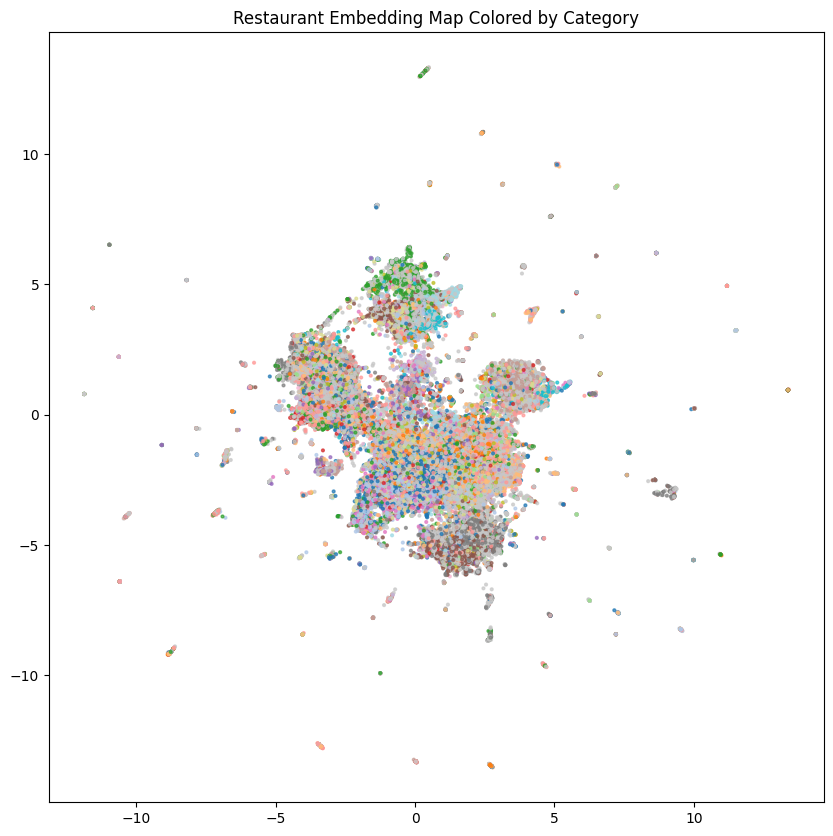

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(
    X_umap[:,0],
    X_umap[:,1],
    c=restaurants["category_id"],
    cmap="tab20",
    s=4,
    alpha=0.7
)
plt.title("Restaurant Embedding Map Colored by Category")
plt.show()

Then, we can graph it more interactively by using Plotly. The graph below shows each restaurant category corresponding to one color. The user can zoomed in and out, and clicking on one category shows restaurants with that category only.

In [40]:
import plotly.express as px

fig = px.scatter(restaurants, x=X_umap[:, 0], y=X_umap[:, 1], color='main_category', hover_data=['main_category'])
config = {'scrollZoom': True}
fig.show(config=config)

Great! The graph looks great! Now, I want to make this even more interactive by allowing the user to input in restaurant name, and then Plotly will show the top 10 restaurants that are most similar to the user-given one.

In [66]:
def find_restaurant(name, df):
  name = name.lower()
  matches = df[df["name"].str.lower().str.contains(name)]

  if len(matches) == 0:
    print("There is no restaurant with the given name. Please try again!")
    return

  #return the first matched restaurant
  return matches.index[0]

In [80]:
def get_10_similar_restaurants(match, embeddings, df, nn):
  idx = find_restaurant(match, df)
  if idx is None:
      return None
  distances, indices = nn.kneighbors([embeddings[idx]])

  #skip the first restaurant because it's the restaurant itself
  similar_idx = indices[0][1:]
  similar_distances = distances[0][1:]

  results = df.iloc[similar_idx].copy()
  results["similarity (%)"] = (1 - similar_distances) * 100
  return df.loc[idx, "name"], results

In [81]:
query = "Vietnamese Food Truck"   # user input
input, results = get_10_similar_restaurants(query, embeddings, restaurants, nn)

print("🔍 Input restaurant:", input)
print("\n🍽 Top 10 similar restaurants:")
print(results)

🔍 Input restaurant: Vietnamese Food Truck

🍽 Top 10 similar restaurants:
                  business_id                         name  \
18511  yWYOb8jHwAQ2UtcGCiovzg                 Viet's Taste   
20635  nwq5cM5tYtQ7AnCnjVUhmg            Saigon Noodle Bar   
2170   wXvbqjS9g9461rnxSCqcag  Nam Viet Vietnamese Cuisine   
22455  H3B6ZCjtQURr0iWBXYmYzg               Pho Washington   

                             address           city state postal_code  \
18511        70-4005 Clover Bar Road  Sherwood Park    AB     T8H 0M4   
20635            8221 Germantown Ave   Philadelphia    PA       19118   
2170                  8150 49th St N  Pinellas Park    FL       33781   
22455  600 Washington Ave, Ste C & D   Philadelphia    PA       19147   

        latitude   longitude  stars  review_count  is_open  \
18511  53.556833 -113.273909    5.0             5        0   
20635  40.074102  -75.202862    4.0            35        1   
2170   27.845980  -82.700500    4.0             6        1   
22